## License

#### Copyright (c) 2024 robert.bhero@gwu.edu, shepherd.chikwawawa@gwu.edu, pamela.chirwa@gwu.edu

#### MIT License
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [1]:
# importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the training and test datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Display the number of rows in the training and test datasets
print(f"Number of rows in training data: {train_data.shape[0]}")
print(f"Number of rows in test data: {test_data.shape[0]}")

# Separate target variable and features in training data
X = train_data.drop(['SalePrice', 'Id'], axis=1)
y = train_data['SalePrice']

# Drop Id column from test data for alignment with training features
X_test = test_data.drop(['Id'], axis=1)

# Preprocess data
# Select numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define transformers for numerical and categorical data
numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create a pipeline that first preprocesses the data, then fits the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

# Split training data for cross-validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the number of rows in training and validation sets
print(f"Number of rows in training subset: {X_train.shape[0]}")
print(f"Number of rows in validation subset: {X_val.shape[0]}")

# Fit the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on training data
y_pred_train = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

# Evaluate the model on validation data
y_pred_val = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
val_mae = mean_absolute_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Evaluate the model on test data (predictions only, no ground truth for RMSE/MAE)
test_predictions = model.predict(X_test)

# Display the metrics neatly
metrics = pd.DataFrame({
    'Dataset': ['Training', 'Validation'],
    'RMSE': [train_rmse, val_rmse],
    'MAE': [train_mae, val_mae],
    'R-squared': [train_r2, val_r2]
})
print(metrics)

# Save the submission file
submission = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': test_predictions
})
submission.to_csv('Submission.csv', index=False)
print("Submission file saved as 'Submission.csv'.")

Number of rows in training data: 1460
Number of rows in test data: 1459
Number of rows in training subset: 1168
Number of rows in validation subset: 292
      Dataset          RMSE           MAE  R-squared
0    Training  11164.323415   6553.593562   0.979103
1  Validation  28775.416959  17519.763630   0.892048
Submission file saved as 'Submission.csv'.


# Correlation Heatman

A heatmap is a graphical representation of data where individual values are represented by varying colors. Heatmaps are widely used for analyzing relationships and feature importance.

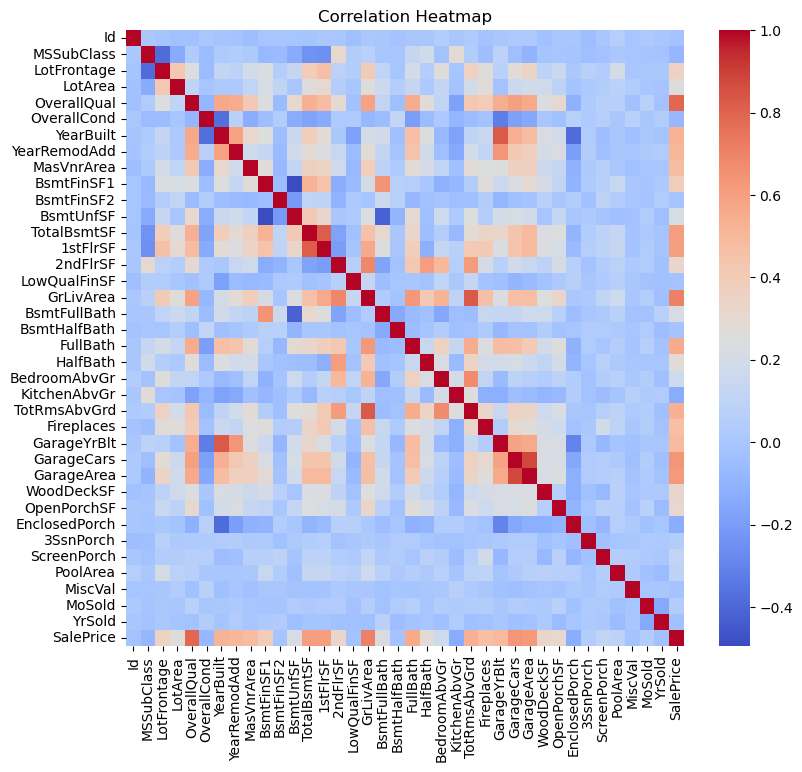

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the training dataset
train_data = pd.read_csv('train.csv')

# Select only numeric columns
numeric_data = train_data.select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric columns
correlation_matrix = numeric_data.corr()

# Draw the heatmap without numbers
plt.figure(figsize=(9, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

# Residual Plot
To visualize the differences between the actual and predicted values (residuals). This helps assess the model's errors and check for patterns, indicating potential biases or issues like heteroscedasticity



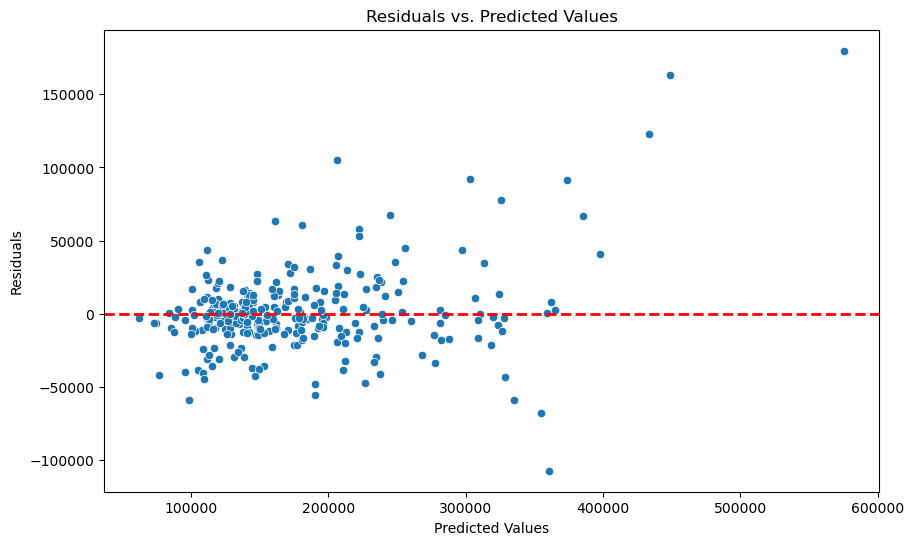

In [3]:
plt.figure(figsize=(10, 6))
residuals = y_val - y_pred_val
sns.scatterplot(x=y_pred_val, y=residuals)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Prediction vs. Actual Values Plot
To compare the predicted values to the actual values, showing how closely the predictions align with reality. Ideally, points should lie along the diagonal line.


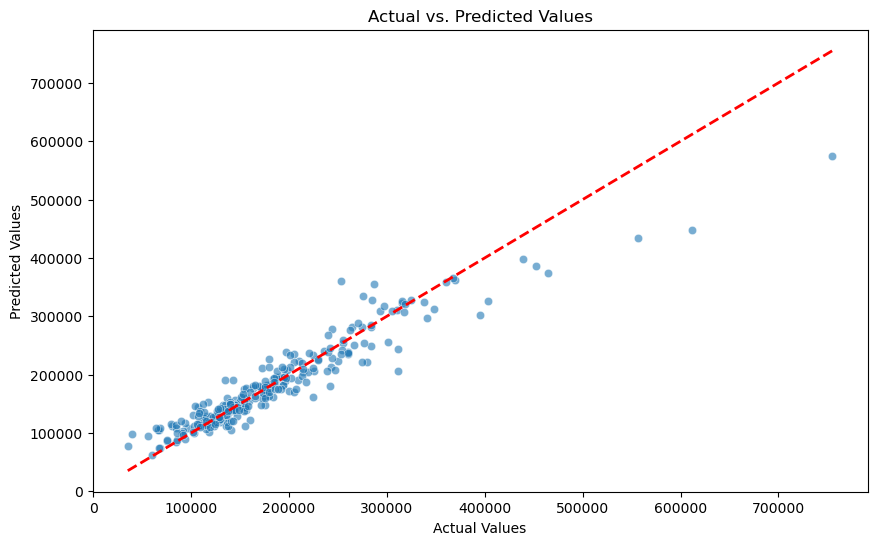

In [4]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val, y=y_pred_val, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', linewidth=2)
plt.title("Actual vs. Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

# Learning Curve
To show how the model's performance changes with different training data sizes. It can reveal underfitting or overfitting.

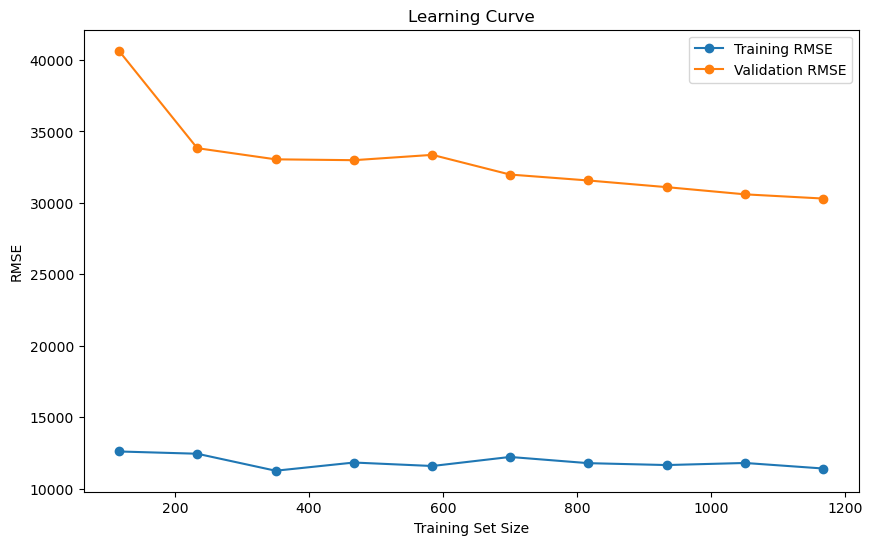

In [5]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse, label="Training RMSE", marker='o')
plt.plot(train_sizes, val_rmse, label="Validation RMSE", marker='o')
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend()
plt.show()